In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, exists
import random
from random import random as rand

from tqdm import tqdm

import clmnlab

/home/sungbeenpark/anaconda3/envs/GA/lib/python3.9/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
GA = clmnlab.GA()

OS : linux
Google Drive is detected!
Git directory is detected!


In [3]:
%config InlineBackend.figure_format = 'retina'
py.offline.init_notebook_mode(connected = True)

In [4]:
np.set_printoptions(precision=5, suppress=True)

In [5]:
def calc_hit(file_behav, tpr, nrun):
    datum = scipy.io.loadmat(file_behav)
    
    ## frame per trial
    fpt = int(datum['nSampleTrial'][0][0])
    ## second per trial
    spt = int(fpt/60.)
    ## a number of trials per run
    # tpr = datum['nTrialperRun'][0][0]
#     tpr = 97  # 12 trial/block * 8 block/run + 1 = 97 trial/run
    ## target ID
    tmp = datum['targetID'][0]
    targetID = tmp[tmp!=0][:tpr*nrun]
#     nrun = 3

    bx = datum['boxSize'][0][0]
    pos = bx*GA.convert_ID(targetID)
    
    ## 60 Hz * {5 s/trial * (1 trial + 12 trial/block * 8 block)}/Run * 3 Run = 87300
    allXY = datum['allXY']
    
    xFrame, yFrame = np.array([datum['xFrame'].squeeze(), datum['yFrame'].squeeze()]).astype(int)
    
    ## target position
    tmp = np.zeros(allXY.shape)
    for i in range(fpt*tpr*nrun):
        t = np.floor(i/fpt).astype(int)
        tmp[0][i], tmp[1][i] = pos[0][t], pos[1][t]

    ## Is it hit?
    err = allXY - tmp
    hit = np.zeros(fpt*tpr*nrun)
    for i in range(fpt*tpr*nrun):
        hit[i] = abs(err[0][i]) <= bx*.5 and abs(err[1][i]) <= bx*.5
        
    return hit

GA

In [6]:
dir_work = '/home/sungbeenpark/Github/labs/GA'
dir_data = join(dir_work, 'behav_data')
list_behav = sorted(glob(join(dir_data, '*-fmri.mat')))

df_GA = pd.DataFrame(columns=['subj']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GA.loc[i]['subj'] = subj
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GA.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GA

100%|██████████| 30/30 [00:16<00:00,  1.81it/s]


,subj,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,GA01,0.225833,0.221389,0.370833,0.316389,0.341389,0.389444,0.266667,0.379444,0.476389,...,0.296389,0.330556,0.352222,0.425278,0.338333,0.431389,0.406111,0.353056,0.440556,0.511944
1,GA02,0.382778,0.487222,0.434722,0.219167,0.381111,0.498611,0.438333,0.391944,0.366389,...,0.3325,0.476389,0.428056,0.5,0.564444,0.500556,0.641389,0.582222,0.634167,0.633889
2,GA05,0.040556,0.402222,0.246389,0.094167,0.221667,0.204167,0.045,0.206944,0.305833,...,0.476944,0.509722,0.666667,0.68,0.532222,0.560833,0.619167,0.631389,0.625833,0.621389
3,GA07,0.146389,0.240833,0.07,0.1925,0.293056,0.286111,0.257222,0.196944,0.233889,...,0.305833,0.334444,0.265278,0.293611,0.307778,0.175,0.171944,0.319444,0.255278,0.408333
4,GA08,0.263889,0.233056,0.411667,0.432222,0.258056,0.673889,0.530833,0.488611,0.341389,...,0.541667,0.517778,0.346389,0.381389,0.501944,0.459167,0.365,0.521944,0.438889,0.461667
5,GA11,0.043611,0.206389,0.144722,0.168611,0.27,0.231111,0.255,0.241111,0.167222,...,0.0875,0.274167,0.144722,0.22,0.170278,0.249722,0.108333,0.141944,0.222222,0.229444
6,GA12,0.132222,0.1525,0.167222,0.368333,0.107778,0.115,0.289167,0.252778,0.234722,...,0.326667,0.336389,0.287778,0.315278,0.211389,0.364722,0.258889,0.336944,0.39,0.434167
7,GA13,0.135833,0.254444,0.338333,0.197778,0.2525,0.346389,0.458056,0.305,0.302778,...,0.453056,0.417222,0.396944,0.44,0.428056,0.433056,0.391944,0.416111,0.409722,0.539722
8,GA14,0.121944,0.128056,0.136944,0.138889,0.281667,0.16,0.0825,0.138056,0.148611,...,0.226111,0.095278,0.190278,0.231111,0.132222,0.199167,0.169444,0.140833,0.09,0.2525
9,GA15,0.108333,0.205278,0.293056,0.185556,0.237222,0.171389,0.233611,0.2225,0.328889,...,0.411944,0.4475,0.236111,0.460556,0.573889,0.435833,0.443333,0.494722,0.476667,0.481667


GB

In [7]:
dir_work = '/home/sungbeenpark/Github/labs/GA'
dir_data = join(dir_work, 'behav_data')
list_behav = sorted(glob(join(dir_data, '*-refmri.mat')))

df_GB = pd.DataFrame(columns=['subj']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GB.loc[i]['subj'] = subj.replace('GA','GB')
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GB.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GB

100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


,subj,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,GB01,0.6625,0.800833,0.651667,0.809167,0.783333,0.798056,0.790556,0.819722,0.809167,...,0.812778,0.762778,0.796944,0.800278,0.775833,0.798333,0.789444,0.82,0.785833,0.7875
1,GB02,0.731944,0.796389,0.824444,0.787778,0.803056,0.785556,0.823889,0.828333,0.7975,...,0.803333,0.816944,0.805,0.8125,0.830556,0.798333,0.808611,0.803611,0.785,0.810556
2,GB05,0.508333,0.633611,0.722778,0.629722,0.694444,0.652778,0.591111,0.624167,0.659167,...,0.8175,0.811667,0.792778,0.825278,0.823611,0.823889,0.818056,0.825278,0.836944,0.826389
3,GB07,0.526944,0.752222,0.755,0.723611,0.709167,0.725278,0.703889,0.732222,0.767778,...,0.555833,0.721389,0.655278,0.608889,0.641667,0.687222,0.730556,0.712222,0.733889,0.714444
4,GB08,0.419444,0.646389,0.641389,0.565,0.718056,0.665556,0.731944,0.596667,0.665833,...,0.679444,0.684444,0.661111,0.594167,0.6725,0.692778,0.722778,0.648889,0.6675,0.590556
5,GB11,0.5975,0.6525,0.618889,0.605,0.555,0.576111,0.525278,0.679722,0.557222,...,0.706389,0.675,0.689167,0.712778,0.726111,0.726111,0.721389,0.731944,0.740833,0.706389
6,GB12,0.562778,0.694722,0.5725,0.618056,0.6025,0.623333,0.606667,0.590833,0.644444,...,0.473889,0.401944,0.529444,0.591667,0.631111,0.673333,0.673056,0.681944,0.657778,0.711111
7,GB13,0.735833,0.726944,0.741111,0.696111,0.744722,0.774444,0.665278,0.6675,0.731667,...,0.689444,0.670556,0.6925,0.693889,0.623056,0.671944,0.681389,0.666389,0.725278,0.734722
8,GB14,0.471667,0.602778,0.605278,0.636111,0.694167,0.696389,0.639167,0.759722,0.748611,...,0.77,0.76,0.698611,0.735556,0.668056,0.673056,0.744722,0.731389,0.785833,0.754444
9,GB15,0.715,0.6825,0.771111,0.741667,0.731944,0.753889,0.751111,0.748056,0.734444,...,0.756111,0.732222,0.7725,0.684722,0.761667,0.751944,0.786944,0.785,0.791944,0.759167


GD

In [8]:
dir_work = '/home/sungbeenpark/Github/labs/GD'
dir_data = join(dir_work, 'behav_data')
list_behav = sorted(glob(join(dir_data, '*-refmri.mat')))

df_GD = pd.DataFrame(columns=['subj']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GD.loc[i]['subj'] = subj
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GD.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GD

100%|██████████| 15/15 [00:08<00:00,  1.72it/s]


,subj,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,GD01,0.185,0.477778,0.471667,0.419444,0.412778,0.5275,0.569444,0.623611,0.683611,...,0.626667,0.716944,0.547778,0.561111,0.599722,0.628056,0.638611,0.600278,0.670833,0.625833
1,GD02,0.570278,0.705278,0.713333,0.755833,0.799444,0.7775,0.774444,0.793889,0.740278,...,0.806111,0.803333,0.834167,0.841944,0.813333,0.826111,0.805556,0.825,0.837222,0.822778
2,GD07,0.379444,0.381111,0.382222,0.514444,0.601111,0.601944,0.610833,0.561667,0.603333,...,0.596944,0.660278,0.403611,0.477778,0.555833,0.563056,0.600833,0.495556,0.676667,0.473611
3,GD11,0.176111,0.408333,0.544444,0.442778,0.447222,0.495,0.513889,0.636389,0.583611,...,0.531389,0.684167,0.666111,0.688889,0.645278,0.755278,0.567222,0.626667,0.645,0.628889
4,GD15,0.206389,0.388333,0.4,0.476944,0.344444,0.5675,0.570556,0.591389,0.627778,...,0.746111,0.707222,0.592778,0.572222,0.679444,0.676111,0.6325,0.732222,0.718611,0.763056
5,GD20,0.224444,0.385833,0.373333,0.418889,0.455278,0.5325,0.413056,0.423611,0.415,...,0.4675,0.412222,0.478056,0.448611,0.434444,0.481111,0.495278,0.478889,0.455278,0.407222
6,GD23,0.699722,0.670833,0.681389,0.723056,0.713889,0.660833,0.548056,0.650833,0.526944,...,0.688889,0.701389,0.687778,0.730278,0.7475,0.673056,0.709167,0.753611,0.72,0.7625
7,GD26,0.553056,0.436111,0.480833,0.507778,0.551389,0.565556,0.570556,0.4825,0.653333,...,0.749167,0.775,0.778056,0.798611,0.791944,0.773611,0.812222,0.811667,0.811944,0.739722
8,GD29,0.281389,0.145,0.133333,0.178056,0.166389,0.091944,0.132222,0.136111,0.179722,...,0.191389,0.230278,0.145556,0.086111,0.211111,0.232222,0.224167,0.161667,0.371111,0.244444
9,GD30,0.553611,0.691111,0.741389,0.728889,0.760833,0.730833,0.733333,0.816389,0.748611,...,0.627778,0.658056,0.790833,0.678889,0.712222,0.699722,0.704722,0.732778,0.646944,0.741667


GP_DLPFC

In [16]:
dir_work = '/home/sungbeenpark/Github/labs/GP'
dir_data = join(dir_work, 'behav_data')
list_behav = []
for s in ['09', '10', '18' ,'21']:
    list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
df_GP_dlpfc = pd.DataFrame(columns=['subj']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GP_dlpfc.loc[i]['subj'] = subj
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GP_dlpfc.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GP_dlpfc

100%|██████████| 4/4 [00:01<00:00,  2.03it/s]


,subj,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,GP09,0.095278,0.006389,0.145833,0.107222,0.157222,0.038056,0.132222,0.089444,0.238333,...,0.180833,0.188889,0.3575,0.069444,0.072222,0.146667,0.169722,0.235,0.208611,0.214722
1,GP10,0.082222,0.167222,0.152222,0.1375,0.251389,0.201944,0.1525,0.150278,0.153056,...,0.194722,0.281944,0.198611,0.273333,0.129167,0.238333,0.224722,0.211944,0.377778,0.420833
2,GP18,0.013611,0.109722,0.098056,0.218056,0.339722,0.181389,0.228333,0.180278,0.246944,...,0.174167,0.174722,0.303056,0.160278,0.179722,0.1575,0.112222,0.033333,0.064722,0.1125
3,GP21,0.032778,0.062222,0.0,0.099167,0.001944,0.071944,0.046389,0.024722,0.014167,...,0.376667,0.493056,0.546111,0.5175,0.598333,0.599444,0.563333,0.561667,0.584444,0.54


GP_M1

In [17]:
dir_work = '/home/sungbeenpark/Github/labs/GP'
dir_data = join(dir_work, 'behav_data')
list_behav = []
for s in ['08', '11', '17', '20']:
    list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
df_GP_m1 = pd.DataFrame(columns=['subj']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GP_m1.loc[i]['subj'] = subj
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GP_m1.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GP_m1

100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


,subj,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,GP08,0.101389,0.081111,0.117222,0.284444,0.3975,0.247778,0.2825,0.390833,0.275278,...,0.465,0.381944,0.387778,0.334444,0.4475,0.473333,0.504444,0.6525,0.541111,0.551111
1,GP11,0.040833,0.350278,0.180833,0.2775,0.373889,0.245278,0.360833,0.186944,0.310278,...,0.1875,0.3375,0.333889,0.392222,0.336667,0.599444,0.711111,0.569444,0.570833,0.663333
2,GP17,0.005556,0.069722,0.135,0.2375,0.247778,0.393056,0.501389,0.415556,0.486667,...,0.478333,0.389167,0.556389,0.491111,0.494722,0.442778,0.4525,0.324722,0.362778,0.386944
3,GP20,0.101667,0.213889,0.298889,0.255278,0.339167,0.229722,0.273056,0.218889,0.182778,...,0.544722,0.525556,0.584722,0.602778,0.534444,0.5575,0.622222,0.635556,0.616667,0.514722


## Comparing

In [18]:
def df_as_long(df):
    df_res = pd.DataFrame(columns=['subj', 'block', 'reward'])
    row = 0
    for i, subj in enumerate(list(df['subj'])):
        for block in range(24):
            df_res.loc[row, 'subj'] = subj
            df_res.loc[row, 'block'] = block
            df_res.loc[row, 'reward'] = df.loc[i, block]
            row += 1
    return df_res

In [19]:
long_df_GA = df_as_long(df_GA)
long_df_GB = df_as_long(df_GB)
long_df_GD = df_as_long(df_GD)
long_df_GP_dlpfc = df_as_long(df_GP_dlpfc)
long_df_GP_m1 = df_as_long(df_GP_m1)

In [20]:
# _, axs = plt.subplots(nrows=6, ncols=5, figsize=(20, 24))
# axs = np.concatenate(axs)
# sns.set_style('whitegrid')

# for i, subj in enumerate(list(df_GA['subj'])):
#     ax = sns.lineplot(x='block', y='reward', data=long_df_GA[long_df_GA.subj==subj], ax=axs[i])
#     ax.set_title(subj)
#     ax.set_xlim(0, 24)
#     ax.set_ylim(0, 1)
#     ax.set_yticks(np.arange(0.,1.,.2))
#     ax.set_ylabel('success rate', size=12)
#     plt.tight_layout()

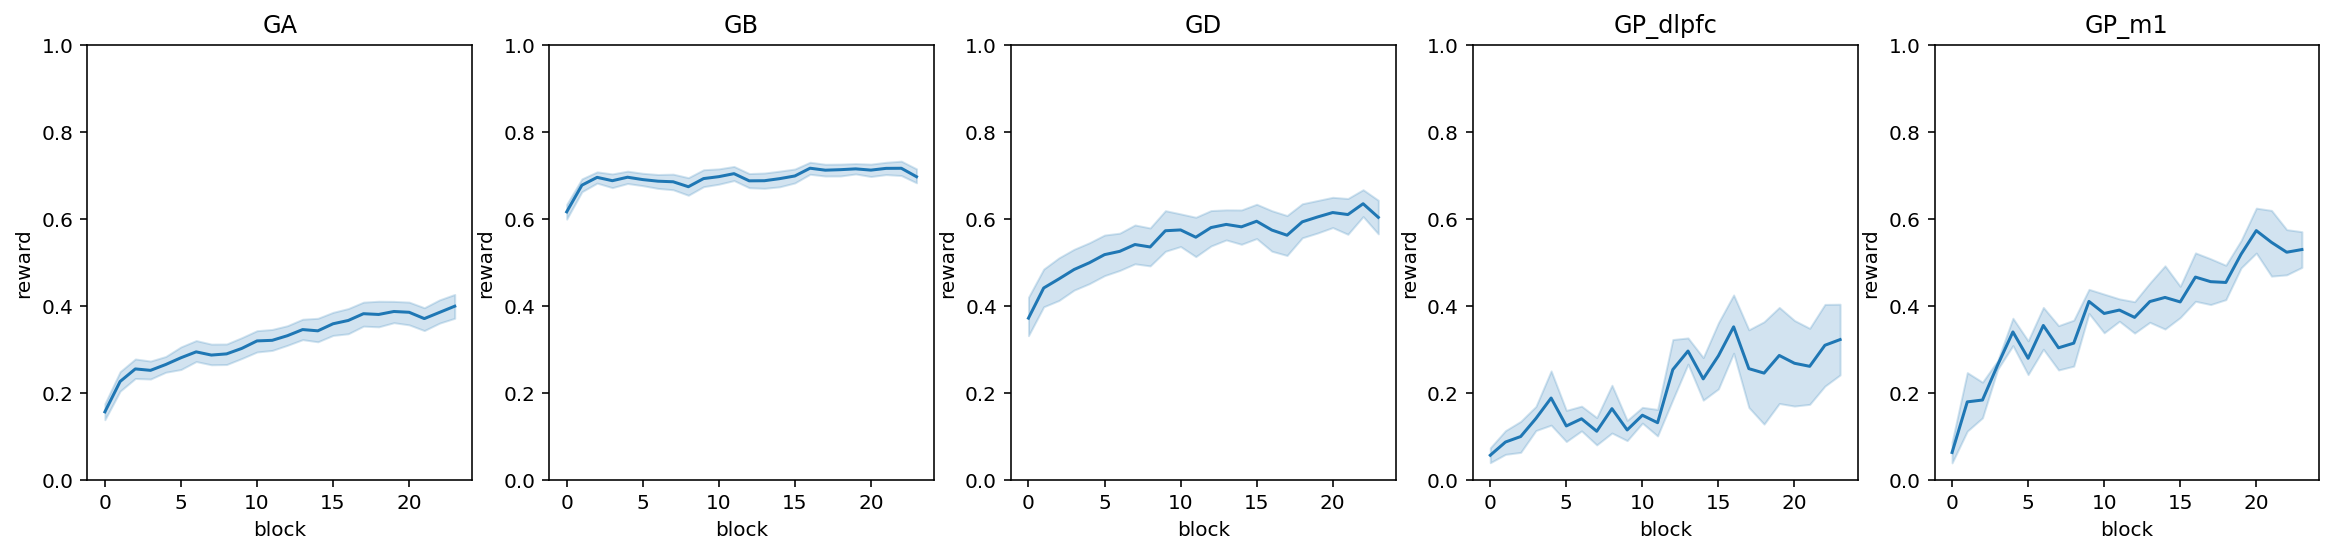

In [22]:
tmp = ['GA', 'GB', 'GD', 'GP_dlpfc', 'GP_m1']

_, axs = plt.subplots(nrows=1, ncols=len(tmp), figsize=(4*len(tmp), 4))

for i, df in enumerate([long_df_GA, long_df_GB, long_df_GD, long_df_GP_dlpfc, long_df_GP_m1]):
    ax = sns.lineplot(x='block', y='reward', data=df, ci=GA.sig1*100, ax=axs[i])
    ax.set(ylim=(0.,1.), title=tmp[i])

In [23]:
df = pd.DataFrame()
row = 0
## GA
for rew in long_df_GA.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GA'
    df.loc[row, 'reward'] = rew
    row += 1
## GB
for rew in long_df_GB.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GB'
    df.loc[row, 'reward'] = rew
    row += 1
## GD
for rew in long_df_GD.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GD'
    df.loc[row, 'reward'] = rew
    row += 1
## GP_DLPFC
for rew in long_df_GP_dlpfc.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GP_DLPFC'
    df.loc[row, 'reward'] = rew
    row += 1
## GP_M1
for rew in long_df_GP_m1.groupby(['subj']).mean()['reward']:
    df.loc[row, 'stage'] = 'GP_M1'
    df.loc[row, 'reward'] = rew
    row += 1

df

,stage,reward
0,GA,0.366991
1,GA,0.446898
2,GA,0.397407
3,GA,0.279699
4,GA,0.442072
...,...,...
78,GP_DLPFC,0.284294
79,GP_M1,0.373090
80,GP_M1,0.364016
81,GP_M1,0.386088


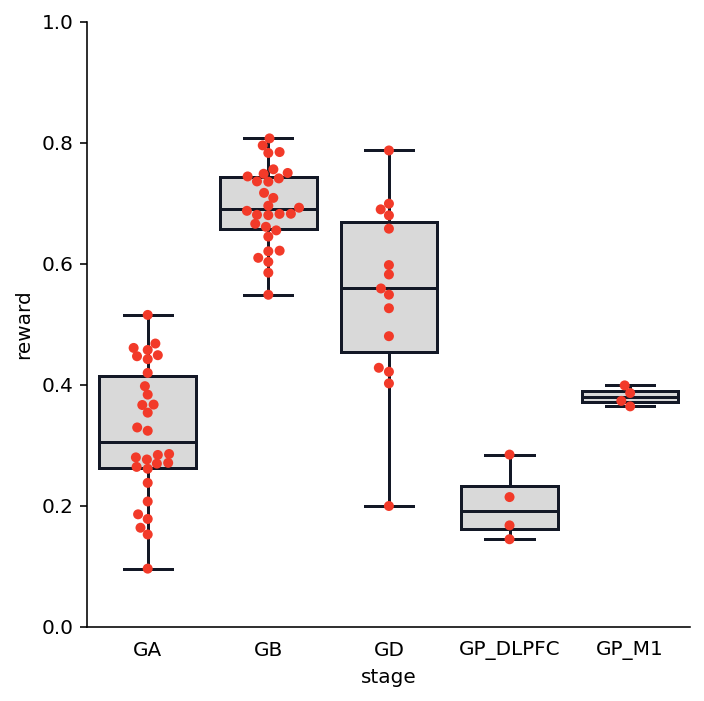

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.boxplot(x='stage', y='reward', data=df, palette=["#D9D9D9"])
sns.swarmplot(x='stage', y='reward', data=df, size=5, color="#F23A29", linewidth=0)

plt.ylim(0, 1.0)
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])

for i, artist in enumerate(ax.artists):
    artist.set_edgecolor("#131826")
    
    for j in range(i*6,i*6+6):
        line = ax.lines[j]
        line.set_color("#131826")
        line.set_mfc("#131826")
        line.set_mec("#131826")
        
#for e, l in zip(early_rwd, late_rwd):
#    line = plt.plot((0, 1), (e, l), '-', linewidth=1)
#    line[0].set_color("#99999999")
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
)

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    right=False,         # ticks along the top edge are off
)

plt.tight_layout()

fig.set_facecolor('white')

# fig.savefig(fname=today+'_behav2.png', dpi=300)

In [25]:
a = list(long_df_GA.groupby(['subj']).mean()['reward'])
p = list(long_df_GP_dlpfc.groupby(['subj']).mean()['reward'])
print('GA vs. GP_DLPFC')
scipy.stats.ttest_ind(a, p, alternative='two-sided')

GA vs. GP_DLPFC


Ttest_indResult(statistic=2.069286867431101, pvalue=0.046675049158739094)

In [26]:
a = list(long_df_GA.groupby(['subj']).mean()['reward'])
p = list(long_df_GP_m1.groupby(['subj']).mean()['reward'])
print('GA vs. GP_M1')
scipy.stats.ttest_ind(a, p, alternative='two-sided')

GA vs. GP_M1


Ttest_indResult(statistic=-1.0925056282693835, pvalue=0.28276791276249097)